In [1]:
#%%writefile plot_kde.py
import pandas as pd 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import argparse

In [2]:
sample_dict = dict(cline='22Rv1', srr='SRR7760384', chrom='chr1')

In [3]:
sample_dict = dict(cline='Nalm6', srr='SRR7410600', chrom='chr1')

In [4]:
# load the x data which corresponds to bin index 
fn = '../../results/main/{cline}/hicnv/tech_run/{cline}_{srr}_hicnv/Kernel_Smoothing/{cline}.{srr}.{chrom}.kde2d_x.txt'
fn = fn.format(**sample_dict)
xdata = pd.read_table(fn, header=None, squeeze=True)

# load y data which corresponds to smoothened read coverage 
fn = '../../results/main/{cline}/hicnv/tech_run/{cline}_{srr}_hicnv/Kernel_Smoothing/{cline}.{srr}.{chrom}.kde2d_y.txt'
fn = fn.format(**sample_dict)
ydata = pd.read_table(fn, header=None, squeeze=True)

# load z data which corresponds to read density
fn = '../../results/main/{cline}/hicnv/tech_run/{cline}_{srr}_hicnv/Kernel_Smoothing/{cline}.{srr}.{chrom}.kde2d_z.txt'
fn = fn.format(**sample_dict)
zdata = pd.read_table(fn, header=None, squeeze=True)

# rename the columns and rows
zdata.columns = ydata
zdata.index = xdata 
zdata = zdata.iloc[:, 0:1000]

In [5]:
# loading the smooth counts
fn = '../../results/main/{cline}/hicnv/tech_run/{cline}_{srr}_hicnv/Kernel_Smoothing/{cline}.{srr}.{chrom}.counts.txt'
fn = fn.format(**sample_dict)
smooth_counts = pd.read_table(fn)

# creating a map for the fragment cut sites
frag_map = smooth_counts[['start.index', 'start']].values.tolist() + smooth_counts[['end.index', 'end']].values.tolist()
frag_map = [tuple(x) for x in frag_map]
frag_map = set(frag_map)
frag_map = {pos: idx for idx, pos in frag_map}
frag_map_idx = {idx: pos for pos, idx  in frag_map.items()}

In [6]:
# loading the copy number segments
fn = '../../results/main/{cline}/hicnv/tech_run/{cline}_{srr}_hicnv/CNV_Estimation/{cline}.{srr}.{chrom}.cnv.bedGraph'
fn = fn.format(**sample_dict)
cnv_segs = pd.read_table(fn, header=None)
cnv_segs.columns = ['chr', 'start', 'end', 'cov', 'cnv', 'class']

/mnt/BioHome/jreyna/software/anaconda3/envs/hic_tls/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


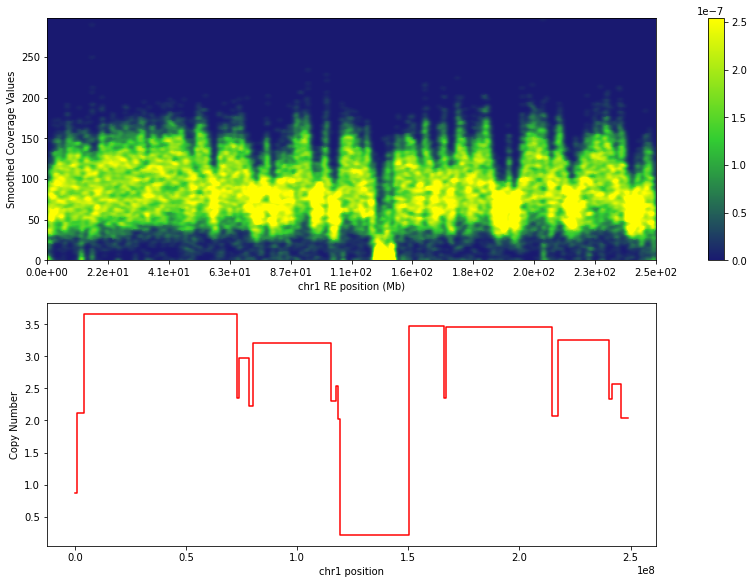

In [9]:
################################### Plot the kernel density ###################################
xi, yi = np.mgrid[zdata.index.min():zdata.index.max() + 1:1, zdata.columns.min():zdata.columns.max():1]

# make a custom colormap which is similar to viridis
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["midnightblue", "navy", "blue", 
                                                         "darkgreen", "green", "lime",
                                                         "greenyellow", "yellow"])
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["midnightblue", "limegreen", "yellow"])

genome_dist = True

# calculate the top quant of nonzero entries
nonzeros = zdata.values.flatten()
nonzeros = nonzeros[nonzeros > 0]
top_quant = np.quantile(nonzeros, 0.95)

# Create a figure
fig = plt.figure(constrained_layout=True, figsize=(11, 8))
gs = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[19, 1])

# plot a pmesh which can make a density plot
ax1 = fig.add_subplot(gs[0, 0])
pmesh = ax1.pcolormesh(xi, yi, zdata.values.reshape(xi.shape), shading='flat', vmin=0, vmax=top_quant, cmap=cmap)

# add a color bar for pmesh
cbar = fig.colorbar(pmesh, ax=ax1)

# label the yaxis 
ax1.set_xlabel('{} RE position (Mb)'.format(sample_dict['chrom']))
ax1.set_ylabel('Smoothed Coverage Values')

# get new tick labels
max_idx = smooth_counts['end.index'].values.max()
possible_ticks = list(range(1, max_idx + 1, int(max_idx/10)))
possible_ticklabels = []

for tick in possible_ticks:
    label = "{:.1e}".format(frag_map_idx[tick]/1000000)
    possible_ticklabels.append(label)

ax1.set_xticks(possible_ticks)
ax1.set_xticklabels(possible_ticklabels)

################################### Plot the CNV data ###################################
xcnv = []
ycnv = [] 
max_xidx = zdata.index.max()

for (start, end, cnv) in cnv_segs[['start', 'end', 'cnv']].values.tolist():
   
    if frag_map[start] > max_xidx:
        print('b')
        break
        
    # adding genomic distance
    if genome_dist == True:
        xcnv.append(start)
        xcnv.append(end)
    
    # adding index information instead 
    else:
        xcnv.append(frag_map[start])
        xcnv.append(frag_map[end])
    
    # add the CNV data
    ycnv.append(cnv)
    ycnv.append(cnv)
    
xcnv = np.array(xcnv)
ycnv = np.array(ycnv)

# getting the second row
ax3 = fig.add_subplot(gs[1,0])

ax3.set_ylabel('Copy Number')
ax3.set_xlabel('{} position'.format(sample_dict['chrom']))
ax3.plot(xcnv, ycnv, color='red')


# fn = 'test.plot.png'

# fig.savefig(fn)

## Plotting the chromosome specific bedGraph

In [31]:
# loading the copy number segments
fn = '../../results/main/{cline}/hicnv/tech_run/{cline}_{srr}_hicnv/CNV_Estimation/{cline}.{srr}.chr1.cnv.bedGraph'
fn = fn.format(**sample_dict)
chrom_data = pd.read_table(fn, header=None)
chrom_data.columns = ['chr', 'start', 'end', 'cov', 'cnv', 'class']

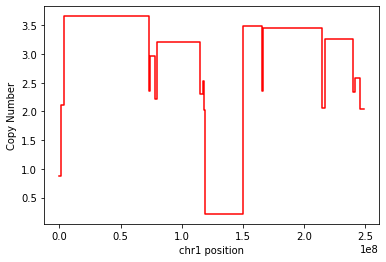

In [32]:
################################### Plot the CNV data ###################################
fig, ax = plt.subplots()
xcnv = []
ycnv = [] 
max_xidx = zdata.index.max()

for (start, end, cnv) in chrom_data[['start', 'end', 'cnv']].values.tolist():

    # adding genomic distance
    if genome_dist == True:
        xcnv.append(start)
        xcnv.append(end)
    
    # adding index information instead 
    else:
        xcnv.append(frag_map[start])
        xcnv.append(frag_map[end])
    
    # add the CNV data
    ycnv.append(cnv)
    ycnv.append(cnv)
    
xcnv = np.array(xcnv)
ycnv = np.array(ycnv)

ax.set_ylabel('Copy Number')
ax.set_xlabel('{} position'.format(sample_dict['chrom']))
ax.plot(xcnv, ycnv, color='red')


# fn = 'test.plot.png'

# fig.savefig(fn)

## Plotting with the full bedGraph file

In [38]:
# loading the copy number segments
fn = '../../results/main/{cline}/hicnv/tech_run/{cline}_{srr}_hicnv/CNV_Estimation/{cline}.{srr}.cnv.bedGraph'
fn = fn.format(**sample_dict)
full_cnv_segs = pd.read_table(fn, header=None)
full_cnv_segs.columns = ['chr', 'start', 'end', 'cov', 'cnv', 'class']

In [39]:
full_cnv_segs.head()

,chr,start,end,cov,cnv,class
0,chr8,0,154422,5.456,0.216,D
1,chr8,154422,158977,5.537,0.219,D
2,chr8,158977,174643,5.618,0.222,D
3,chr8,174643,179858,5.699,0.225,D
4,chr8,179858,202146,5.780,0.229,D


In [40]:
chrom_grps = full_cnv_segs.groupby('chr')
chrom_data = chrom_grps.get_group('chr1')

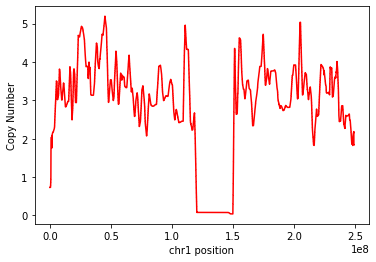

In [42]:
################################### Plot the CNV data ###################################
fig, ax = plt.subplots()
xcnv = []
ycnv = [] 
max_xidx = zdata.index.max()

for (start, end, cnv) in chrom_data[['start', 'end', 'cnv']].values.tolist():

    # adding genomic distance
    if genome_dist == True:
        xcnv.append(start)
        xcnv.append(end)
    
    # adding index information instead 
    else:
        xcnv.append(frag_map[start])
        xcnv.append(frag_map[end])
    
    # add the CNV data
    ycnv.append(cnv)
    ycnv.append(cnv)
    
xcnv = np.array(xcnv)
ycnv = np.array(ycnv)

ax.set_ylabel('Copy Number')
ax.set_xlabel('{} position'.format(sample_dict['chrom']))
ax.plot(xcnv, ycnv, color='red')


# fn = 'test.plot.png'

# fig.savefig(fn)

## Plotting with the full TXT file

In [46]:
# loading the copy number segments
fn = '../../results/main/{cline}/hicnv/tech_run/{cline}_{srr}_hicnv/CNV_Estimation/{cline}.{srr}.cnv.txt'
fn = fn.format(**sample_dict)
full_cnv_segs = pd.read_table(fn)

In [47]:
full_cnv_segs.head()

,chr,start.index,end.index,norm.count,start,end,frag,smooth_count,state,cnv,cnv_label
0,chr8,1,2,0.098765,0,154422,154422,5.456,7,0.216,D
1,chr8,2,3,4.300000,154422,158977,4555,5.537,7,0.219,D
2,chr8,3,4,1.444444,158977,174643,15666,5.618,7,0.222,D
3,chr8,4,5,7.454545,174643,179858,5215,5.699,7,0.225,D
4,chr8,5,6,0.825000,179858,202146,22288,5.780,7,0.229,D


In [48]:
chrom_grps = full_cnv_segs.groupby('chr')
chrom_data = chrom_grps.get_group('chr1')

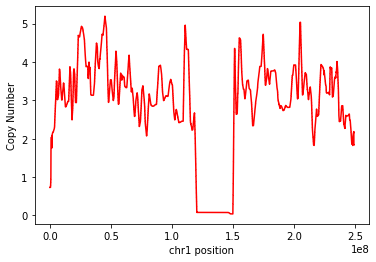

In [49]:
################################### Plot the CNV data ###################################
fig, ax = plt.subplots()
xcnv = []
ycnv = [] 
max_xidx = zdata.index.max()

for (start, end, cnv) in chrom_data[['start', 'end', 'cnv']].values.tolist():

    # adding genomic distance
    if genome_dist == True:
        xcnv.append(start)
        xcnv.append(end)
    
    # adding index information instead 
    else:
        xcnv.append(frag_map[start])
        xcnv.append(frag_map[end])
    
    # add the CNV data
    ycnv.append(cnv)
    ycnv.append(cnv)
    
xcnv = np.array(xcnv)
ycnv = np.array(ycnv)

ax.set_ylabel('Copy Number')
ax.set_xlabel('{} position'.format(sample_dict['chrom']))
ax.plot(xcnv, ycnv, color='red')


# fn = 'test.plot.png'

# fig.savefig(fn)

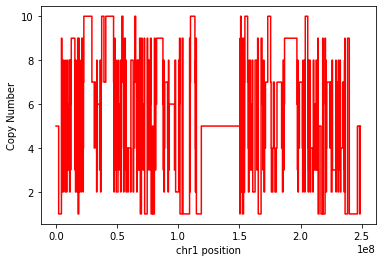

In [50]:
################################### Plot the CNV data ###################################
fig, ax = plt.subplots()
xcnv = []
ycnv = [] 
max_xidx = zdata.index.max()

for (start, end, cnv) in chrom_data[['start', 'end', 'state']].values.tolist():

    # adding genomic distance
    if genome_dist == True:
        xcnv.append(start)
        xcnv.append(end)
    
    # adding index information instead 
    else:
        xcnv.append(frag_map[start])
        xcnv.append(frag_map[end])
    
    # add the CNV data
    ycnv.append(cnv)
    ycnv.append(cnv)
    
xcnv = np.array(xcnv)
ycnv = np.array(ycnv)

ax.set_ylabel('Copy Number')
ax.set_xlabel('{} position'.format(sample_dict['chrom']))
ax.plot(xcnv, ycnv, color='red')


# fn = 'test.plot.png'

# fig.savefig(fn)